# Algorithm

## Dynamic FastMap

**Solves "Patching" Problem:**
Find an optimal inear transformation of the FastMap embedding produced at timestep $t$ that minimizes the “difference” relative to the embedding at timestep $t−1$.

**Input:** 
- Total of $T$ snapshots $G^t$ of a dynamic graph on $N$ vertices.
    - $t /in /{1...T/}$
    - $/kappa$: Number of spatial dimensions for the embedding
- $/epsilon$: threshold parameter required for invoking FastMap as a subroutine

**Output:** 
- Sequence of Embeddings: $Z^t = [z^t_1,z^t_2,...,z^t_N]$ for $i/in/{1,2,...,N/}$, $t/in/{0,1,...,T/}$

**Initiation:**
- Obtain FastMap embedding $Z^0$ of $G^0$

**Loop** for $t/in/{1,2,...,T/}$:
1. Obtain FastMap embedding $X^t$ from $G^t$
2. Patching $X^t$ to $Z^t$
    - **Purpose:** To preserve Pairwise differences
    - **Medthod:** 
        - Finding the Linear Transformation $A$ and $b$ that minimizes the difference between $Z^t$ and $Z^t-1$ using Gurobi
        - Performing Linear Transformation $X^t$ to $Z^t$

## SNAP Standford Social Networks ([Link](https://snap.stanford.edu/data/#socnets))

In [1]:
import networkx as nx
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Datasets

In [2]:
#Facebook Dataset
dir = "C:/Users/ruiji/Documents/USC/Research/PHY760/Data/Social Networks/Facebook/"

In [3]:
GraphType = nx.Graph()

In [4]:
FB_Net = nx.read_edgelist(
    dir+"facebook_combined.txt", 
    create_using=GraphType,
    nodetype=int
)

In [6]:
nx.draw(test_net, node_size=50)
plt.show()

NameError: name 'test_net' is not defined

## Subgraphs

In [7]:
def gen_rand_subgraphs(graph,N=10,size=200):
    result = []
    random_source_nodes = random.sample(graph.nodes,N)
    for node in random_source_nodes:
        remain_nodes = list(nx.shortest_path(graph, source=node).keys())[:size]
        subgraph = graph.subgraph(remain_nodes).copy()
        result.append(subgraph)
    return result

In [144]:
FB_SubGraphs = gen_rand_subgraphs(FB_Net)

C:\Users\ruiji\AppData\Local\Temp/ipykernel_4140/1179480307.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_source_nodes = random.sample(graph.nodes,N)


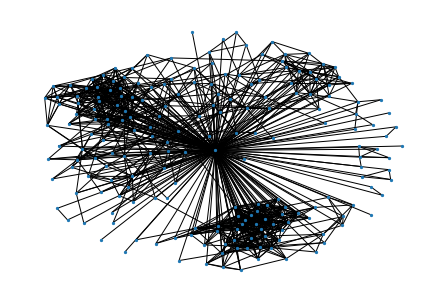

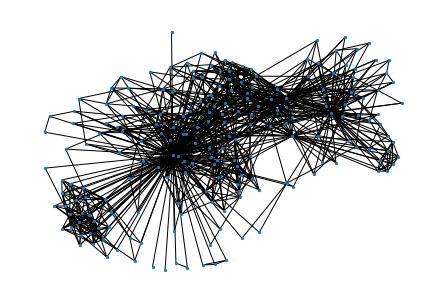

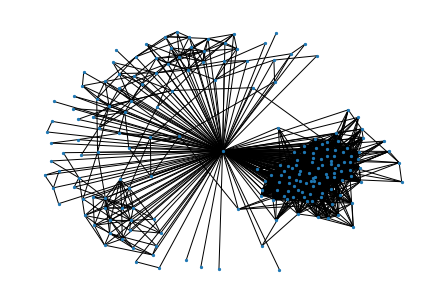

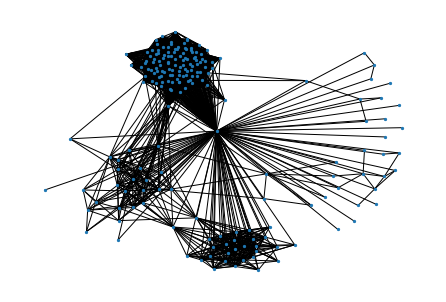

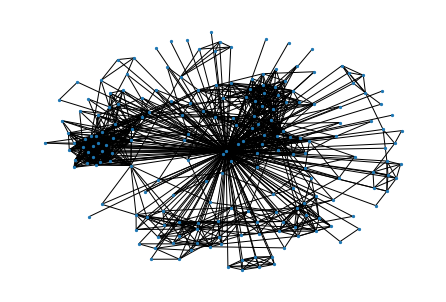

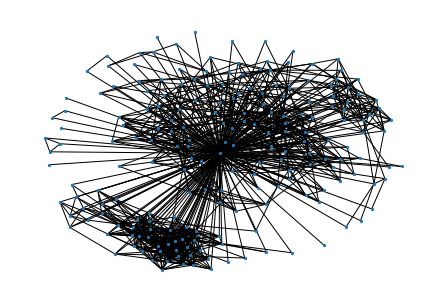

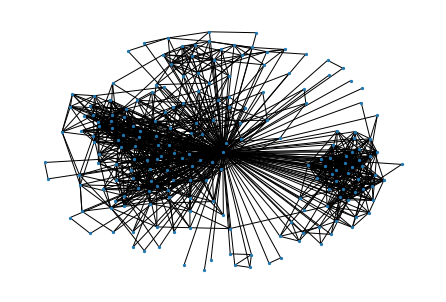

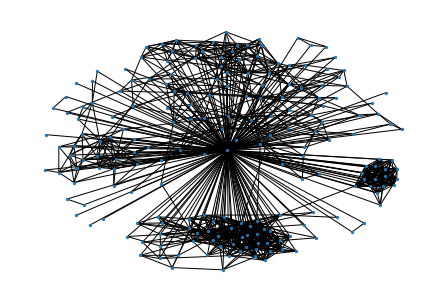

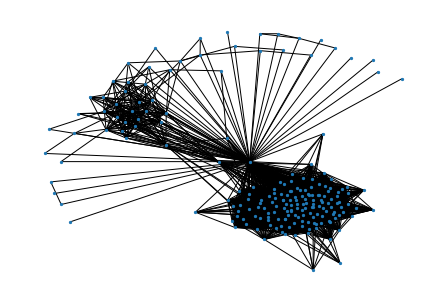

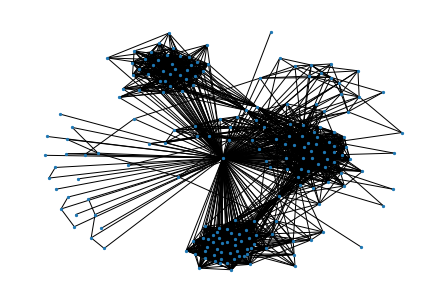

In [40]:
for graph in FB_SubGraphs:
    #print(len(graph.nodes))
    nx.draw(graph, node_size=5)
    plt.show()

## Plot

In [6]:
def plot(map_result,keywords_list,m=2,annotate=True,node=None,membership='blue'):
    ax_min = np.min(map_result)*1.2
    ax_max = np.max(map_result)*1.2
    fig = plt.figure(figsize=(12,10))
    if m == 2:
        ax = fig.add_subplot()
        ax.scatter(map_result[:,0], map_result[:,1],c=membership)
        ax.set_xlim(ax_min,ax_max)
        ax.set_ylim(ax_min,ax_max)
        if annotate:
            for (label,x,y) in zip(keywords_list,map_result[:,0],map_result[:,1]):
                plt.annotate(label, (x, y))
        if node:
            id = keywords_list.index(node)
            plt.scatter(map_result[id,0],map_result[id,1],color="red")
            plt.annotate(node, (map_result[id,0], map_result[id,1]))
        plt.show
    else:
        ax = plt.axes(projection='3d')
        ax.scatter3D(map_result[:,0], map_result[:,1], map_result[:,2])
        ax.set_xlim(ax_min,ax_max)
        ax.set_ylim(ax_min,ax_max)
        ax.set_zlim(ax_min,ax_max)
        if node:
            id = keywords_list.index(node)
            ax.scatter3D(map_result[id,0],map_result[id,1],map_result[id,2],color="red")
        '''for (label,x,y,z) in zip(keywords_list,map_result[:,0],map_result[:,1],map_result[:,2]):
            plt.annotate(label, (x,y,z))'''
        plt.show

In [194]:
test_net = FB_SubGraphs[8].copy()
test_net_C = nx.complement(test_net)

# SS-PASPD Function for Block Modeling
### (Single-Source Probabilistically-Amplified Shortest-Path)

In [31]:
def nansum_fixed(a, **kwargs):
    mx = np.isnan(a).all(**kwargs)
    res = np.nansum(a, **kwargs)
    res[mx] = np.nan
    return res

In [32]:
def SS_SPD(graph,vs):
    nx_sp = nx.single_source_shortest_path_length(graph,vs)
    result = np.array([nx_sp[vi] if vi in nx_sp else np.nan for vi in graph.nodes])
    return result

In [33]:
def SS_PASPD(Go, Go_, vs, L=4, F=10):
    Gset = []
    Tset = []
    for l in range(L):
        G = Go.copy()
        G_ = Go_.copy() #Too slow
        '''with open(Go_,"rb") as handle:
            G_ = pickle.load(handle)'''
        if len(G_.edges) > len(G.edges):
            E_to_drop = random.sample(list(G_.edges),len(G_.edges) - len(G.edges))
            G_.remove_edges_from(E_to_drop)
        Gset.append(G)
        f = int(len(G.edges)/F)
        def drop_till_none(graph):
            while len(graph.edges)>=f:
                E_to_drop = random.sample(list(graph.edges),f)
                graph.remove_edges_from(E_to_drop)
                Gset.append(graph.copy())
            Gset.append(graph)
        drop_till_none(G)
        drop_till_none(G_)
    for Gi in Gset:
        Ti = SS_SPD(Gi,vs)
        Tset.append(Ti)
    Ds = nansum_fixed(np.array(Tset),axis=0)
    #Ds[np.isnan(Ds)] = np.nanmax(Ds)*2

    Ds = np.array([ np.nanmax(Ds)*2 if np.isnan(di) else di for di in Ds]) #replace nan distance with twice max
    return Ds

# FastMap Network using SS-PASPD

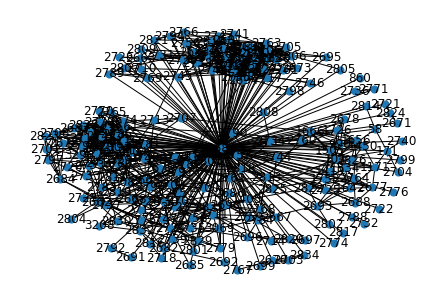

In [42]:
nx.draw(test_net,node_size=50, with_labels=True)
plt.show()

test_nodes = list(test_net.nodes)

In [43]:
import warnings
warnings.simplefilter("default")

In [34]:
class BlockModeling_FastMap:
    
    def __init__(self, L=4, F=10, Q=10, eta=10e-4):
        self.L = L
        self.F = F
        self. Q = Q
        self.eta = eta
        self.D = None
        return

    def gen_D(self):
        D = []
        for node in self.nodes:
            #print(SS_SPD(test_net,node))
            Ds = SS_PASPD(self.G, self.G_C, node, L=self.L, F=self.F)
            D.append(Ds)
        return np.array(D)

    def fit(self,G,K=2):
        self.K = K
        self.G = G.copy()
        self.nodes = list(self.G.nodes)
        self.G_C = nx.complement(self.G).copy()
        #self.D = self.gen_D() # Pre calculated Distance Matrix
        self.P = np.zeros((len(self.nodes),self.K))# Coordinates
        for r in range(self.K):
            # Find Furthest Pair
            va = random.sample(self.nodes,1)[0]
            a = self.nodes.index(va)
            vb = va
            #for q in range(self.Q):
            while True:
                da = SS_PASPD(self.G,self.G_C,va) #self.D[a]
                c = np.argmax(np.square(da)-np.sum(np.square(self.P[a]-self.P), axis=1))
                vc = self.nodes[c]
                if vc==vb:
                    break
                else:
                    vb=va
                    va=vc
            
            # Find origin and furthest coord
            a = self.nodes.index(va)
            b = self.nodes.index(vb)
            da = SS_PASPD(self.G,self.G_C,va)
            db = SS_PASPD(self.G,self.G_C,vb)
            dab = (da[b]+db[a])/2
            dab_ = np.square(dab)-np.sum(np.square(self.P[a]-self.P[b]))
            if dab_ < self.eta:
                break
            
            # Find all Coordinates
            for i,node in enumerate(self.nodes):
                dai_ = np.square(da[i])-np.sum(np.square(self.P[a]-self.P[i]))
                dib_ = np.square(db[i])-np.sum(np.square(self.P[i]-self.P[b]))
                self.P[i,r] = (dai_+dab_-dib_)/(2*np.sqrt(dab_))
        return self.P




In [35]:
myFM = BlockModeling_FastMap()

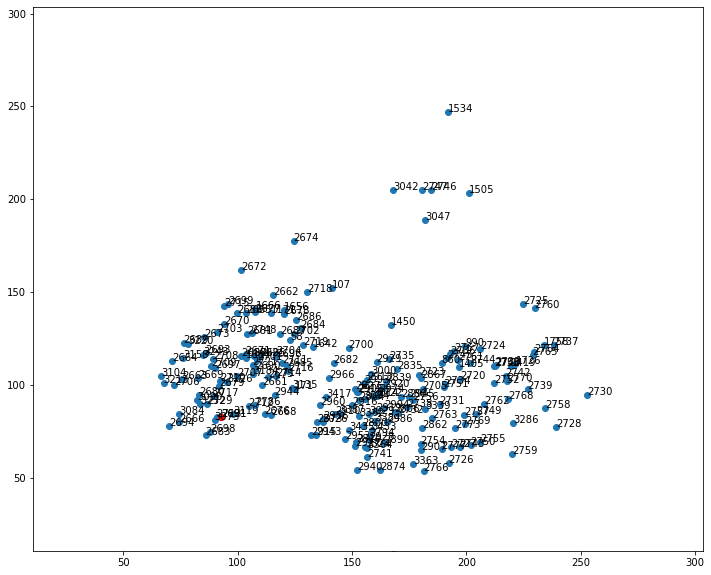

In [40]:
test_c = myFM.fit(test_net,K=3)
plot(test_c,list(test_net.nodes), m=2,annotate=True,node=2691)

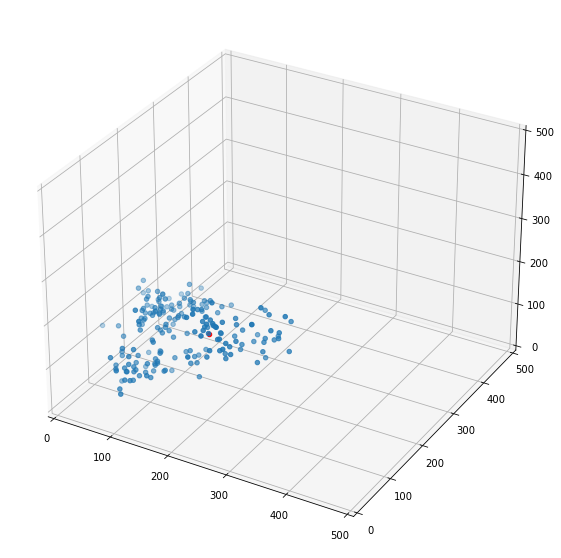

In [ ]:
plot(test_c,list(test_net.nodes), m=3,node=2875)

In [ ]:
c_map = ['red' if node in [2875] else 'blue' for node in test_net.nodes]

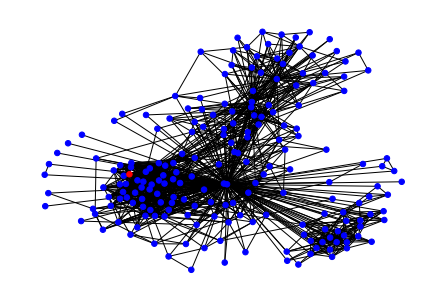

In [ ]:
nx.draw(test_net,node_size=30, node_color=c_map, with_labels=False)
plt.show()

# Import FMBM

In [10]:
import fastmap_graphs as fmg


In [57]:
import importlib
importlib.reload(fmg)

<module 'fastmap_graphs' from 'c:\\Users\\ruiji\\Documents\\USC\\Research\\PHY760\\Notes\\fastmap_graphs.py'>

In [191]:
test_adj_mat = nx.adjacency_matrix(test_net)

In [192]:
K, e, T, M, isBM, times = 2, 0.0001, 12, 5, True, 5
k_clusters = 2
labels, score, runtime, G, fm_embedding = fmg.bestscore_choice(test_adj_mat, K, e, k_clusters, T, times, isBM)

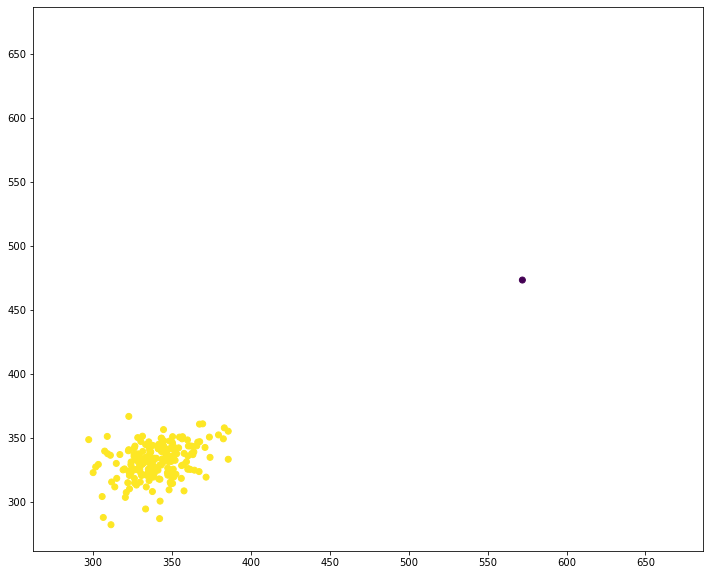

In [193]:
plot(fm_embedding,list(test_net.nodes),m=2,annotate=False,membership=labels)

In [30]:
g_c = nx.complement(test_net)
min = 201
max = 0
max_node = 0
min_node = 0
for node in test_net.nodes:
    obs_node = 2662
    l = len([e for e in g_c.edges if node in e])
    print(f"{node}:{l}")
    if l>max:
        max = l
        max_node = node
    elif l<min:
        min = l
        min_node = node

3073:153
2748:189
3084:150
3090:133
3104:143
3119:150
58:196
3135:171
3158:160
2661:190
2662:193
2663:188
2664:147
2665:193
1642:191
107:184
2666:164
2667:195
2668:195
2669:140
3184:164
2670:195
2671:197
2672:194
2673:179
2674:194
2675:194
2679:130
1656:191
2676:157
2677:193
2683:145
2678:194
2680:171
2681:167
2682:195
2684:194
2689:152
1666:190
2685:197
2686:196
2687:194
2694:141
2688:194
2690:192
2691:198
2698:158
2692:197
2693:194
3213:174
2695:191
2696:195
2697:197
2699:196
2706:155
1171:192
1684:0
3220:152
2701:194
2702:193
2703:196
2704:197
3226:156
2707:196
2708:193
2709:196
2710:194
2711:191
3232:135
2712:195
2713:196
2714:197
2715:196
2716:187
2717:171
2718:197
2719:189
2729:155
2721:197
3243:175
171:193
2724:188
2725:195
2726:193
2727:197
2728:194
2738:145
2730:188
2731:182
2741:161
2733:198
2743:162
2735:195
2736:198
2737:193
2739:195
2740:197
2749:164
1726:191
2742:188
2744:196
2745:184
2754:124
2755:146
2756:164
2757:150
2750:144
2751:194
2752:196
2753:191
2758:194
2763:15

In [39]:
max_node

2691

# Patching

In [14]:
import gurobipy as gp
from gurobipy import GRB

## using Gurobi

In [ ]:
#input
Z0 = BMFM_test_subnets[0][1] # Block modeling FastMap Coordinates
X1 = BMFM_test_subnets[1][1]
K = 3
N = len(X1) #200

In [ ]:
m = gp.Model("Patching") # Create Model

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-30


In [ ]:
m.params.NonConvex = 2

Set parameter NonConvex to value 2


In [ ]:
A = m.addMVar((K,K))
b = m.addMVar(K)
Y = m.addMVar((N,K), lb=-GRB.INFINITY, name='Y')

In [ ]:
m.addConstrs((Y[j] == sum([X1[j][i] * A[:,i] for i in range(K)])+b-Z0[j] for j in range(N)), name='set_Y')
m.addConstrs((A[:,i]@A[:,i]==1 for i in range(K)), name='set A linear trans')
for i in range(K):
    for j in range(i+1,K):
        m.addConstr((A[:,i]@A[:,j]==0), name=f'set A orthogonal_{i}_{j}')

In [ ]:
m.update()

In [ ]:
m.setObjective(sum([Y[i,:] @ Y[i,:] for i in range(N)]), GRB.MINIMIZE)

In [ ]:
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 600 rows, 612 columns and 3000 nonzeros
Model fingerprint: 0xea868d67
Model has 600 quadratic objective terms
Model has 6 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+02]
  QRHS range       [1e+00, 1e+00]

Continuous model is non-convex -- solving as a MIP

Presolve added 18 rows and 9 columns
Presolve time: 0.02s
Presolved: 648 rows, 630 columns, 3090 nonzeros
Presolved model has 600 quadratic objective terms
Presolved model has 9 bilinear constraint(s)
Variable types: 621 continuous, 9 integer (9 binary)

Root relaxation: objective 3.599241e+06, 702 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Ob

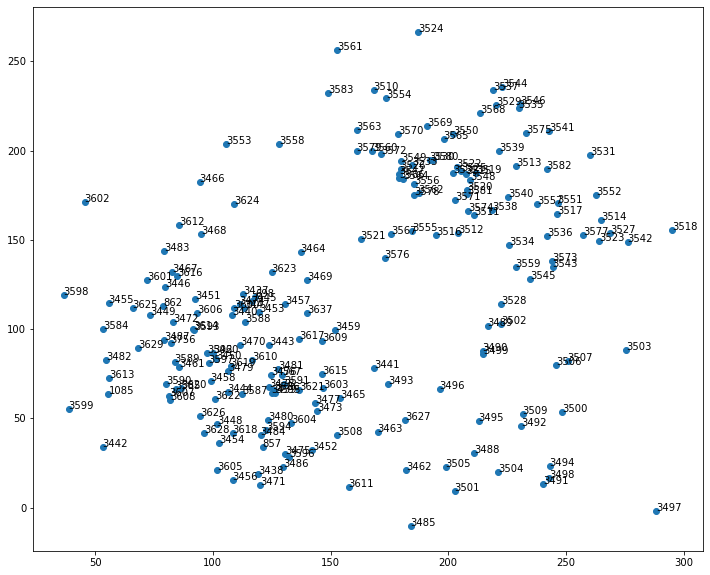

In [ ]:
plot(Z0,BMFM_test_subnets[0][0].nodes,m=2)

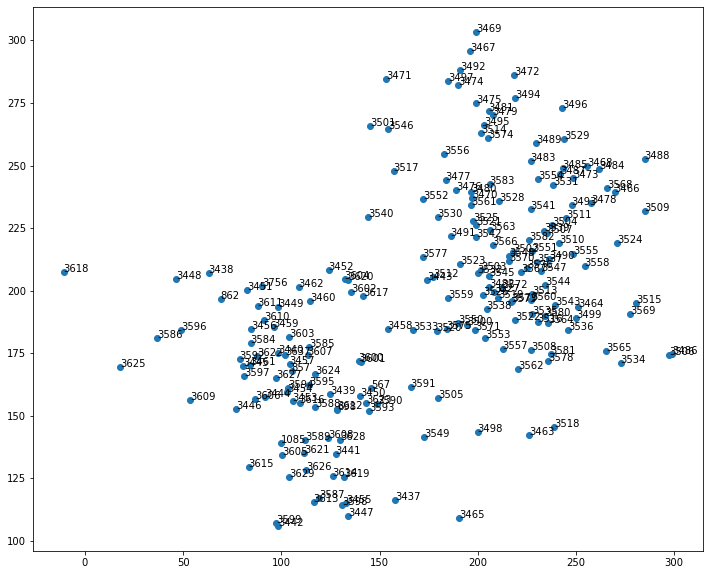

In [ ]:
plot(X1,BMFM_test_subnets[1][0].nodes,m=2)

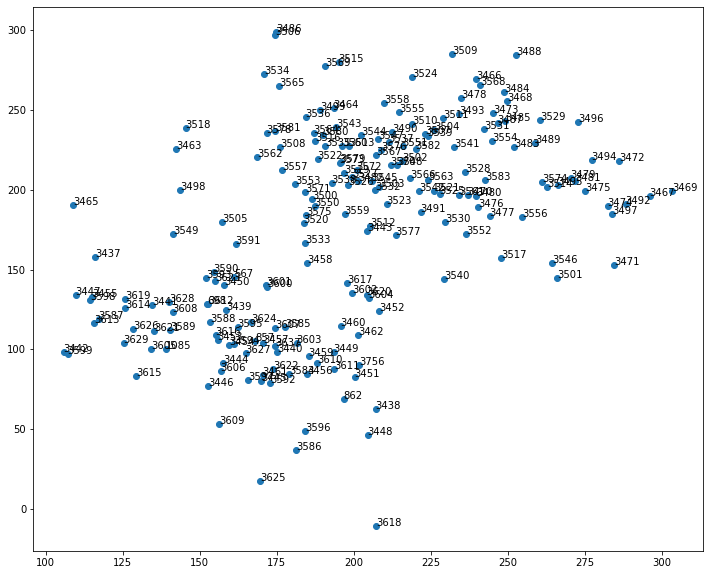

In [ ]:
T_X1 = X1@A.X+b.X
plot(T_X1,BMFM_test_subnets[1][0].nodes,m=2)

## Gurobi_Patch_Solver

In [15]:
def Gurobi_Patch_Solver(Z0,X1):
    K = Z0.shape[1]
    N = Z0.shape[0]
    m = gp.Model("Patching") # Create Model
    m.params.NonConvex = 2
    A = m.addMVar((K,K))
    b = m.addMVar(K)
    Y = m.addMVar((N,K), lb=-GRB.INFINITY, name='Y')
    m.addConstrs((Y[j] == sum([X1[j][i] * A[:,i] for i in range(K)])+b-Z0[j] for j in range(N)), name='set_Y')
    m.addConstrs((A[:,i]@A[:,i]==1 for i in range(K)), name='set A linear trans')
    for i in range(K):
        for j in range(i+1,K):
            m.addConstr((A[:,i]@A[:,j]==0), name=f'set A orthogonal_{i}_{j}')
    m.update()
    #m.setObjective(sum([Y[i,:] @ Y[i,:] for i in range(N)]), GRB.MINIMIZE)
    obj = sum(Y[i] @ Y[i] for i in range(N))
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()
    beta = np.mean(Z0-X1,axis = 0)
    print(beta)
    Z1 = X1@A.X+beta
    return Z1

In [ ]:
def compute_rotation_matrix(points_old, points_new):
	n = points_old[:,0].size
	d = points_old[0].size
	#print(points_old)
	#print(points_new)

	# Create a new model
	env = gp.Env(empty=True)
	env.setParam("OutputFlag",0)
	env.start()
	m = gp.Model("qp")
	m.params.NonConvex = 2
	m.Params.LogToConsole = 0

	# Create variables (x and y are referred to as A and b in the paper)
	x = m.addMVar((d,d), lb=-1, ub=1, vtype=GRB.CONTINUOUS, name="x")
	z = [m.addMVar(d, vtype=GRB.CONTINUOUS, name="z"+str(i)) for i in range(n)] #denotes difference Ax + b - y
	#z = m.addMVar((n,d), lb=-GRB.INFINITY, name='z')
	y = m.addMVar(d, vtype=GRB.CONTINUOUS, name="y")

	# Set objective (minimize sum of squared deviations)
	obj = sum(z[i] @ z[i] for i in range(n))
	m.setObjective(obj, gp.GRB.MINIMIZE)

	# Add constraints:
	# 1) assign meaning to z (deviations in points after rotation)
	for i in range(n):
		m.addConstrs(z[i][j] >= sum([x[j][k] * points_new[i][k] for k in range(d)]) + y[j] - points_old[i][j] for j in range(d))
		m.addConstrs(z[i][j] >= points_old[i][j] - sum([x[j][k] * points_new[i][k] for k in range(d)]) - y[j] for j in range(d))
	#m.addConstrs((z[j] == sum([points_new[j][i] * x[:,i] for i in range(d)])+y-points_old[j] for j in range(n)), name='set_Y')
	
	# 2) x should be orthogonal
	for i in range(d):
		m.addConstr(x[:,i] @ x[:,i] == 1)
	for i in range(d):
		for j in range(i+1, d):
			#print("adding constraint for zero dot " + str(i) + str(j))
			m.addConstr(x[:,i] @ x[:,j] == 0)
	print("optimizing")

	#print('Added constraints')
	# Optimize model
	m.write("lpfile.lp")
	m.optimize()
	#print('tried to optimize rotation matrix')
	if (m.status != gp.GRB.OPTIMAL):
		print('compute iis because status is %g' % m.status)
		m.computeIIS()
		m.write("iis.ilp")
		return
	else:
		rotated_points = np.full((n,d), 0.0)
		#uncomment the print statements for debugging if needed:
		for i in range(n):
			#print(z[0].x + points_old[0])
			rotated_points[i] = np.matmul(x.X, points_new[i]) + np.array(y.X)
			#print(points_old[i], rotated_points[i], z[i].X)
		#for v in m.getVars():
			#print('%s = %g' % (v.varName, v.x))
		#print('Obj: %g' % obj.getValue())
		#print(m.objVal)
		return rotated_points

# Test

## Create Test Scenarios

### 1. Single Point Changing Group

In [42]:
def New_User_Scene(graph, node, N = 3):
    result = [graph]
    g = graph.copy()
    g_C = nx.complement(g)
    connected_e = [e for e in g.edges if node in e]
    unconnected_e = [e for e in g_C.edges if node in e]
    delta = int(len(unconnected_e)/N)
    for y in range(N-1):
        #edges_to_drop = random.sample(connected_e,int(len(connected_e)/N))
        edges_to_add = random.sample(unconnected_e,delta)
        for edge in edges_to_add:
            unconnected_e.remove(edge)
        #g.remove_edges_from(edges_to_drop)
        g.add_edges_from(edges_to_add)
        result.append(g.copy())
    return result[::-1]

In [43]:
scg_test_series = New_User_Scene(test_net, 2691, N = 3)

In [44]:
K, e, T, M, isBM, times = 4, 0.0001, 10, 4, True, 5
k_clusters = 2
obs_node = 939
BMFM_test_subnets = []
for i,test_subnet in enumerate(scg_test_series):
    print(f'Graph: {i+1}')
    labels, score, runtime, G, fm_embedding = fmg.bestscore_choice(test_adj_mat, K, e, k_clusters, T, times, isBM)
    #plot(fm_embedding,list(test_subnet.nodes), m=2, annotate=False, node=obs_node)
    BMFM_test_subnets.append((test_subnet,fm_embedding))
    

Graph: 1
Graph: 2
Graph: 3


In [49]:
with open('../Data/BMFM_test_subnets.pickle','wb') as handle:
    pickle.dump(BMFM_test_subnets,handle)

In [14]:
with open('../Data/BMFM_test_subnets.pickle','rb') as handle:
    BMFM_test_subnets = pickle.load(handle)

In [ ]:
node_list = list(BMFM_test_subnets[0][0].nodes)
patched_subnets = []
Z0 = BMFM_test_subnets[0][1]
patched_subnets = [Z0]
for i in range(1,len(BMFM_test_subnets)):
    X1 = BMFM_test_subnets[i][1]
    Z1 = Gurobi_Patch_Solver(Z0,X1)
    patched_subnets.append(Z1)

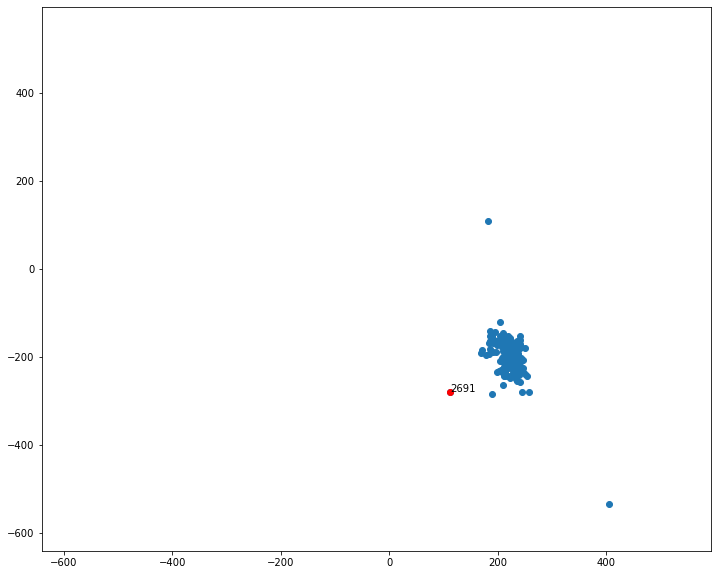

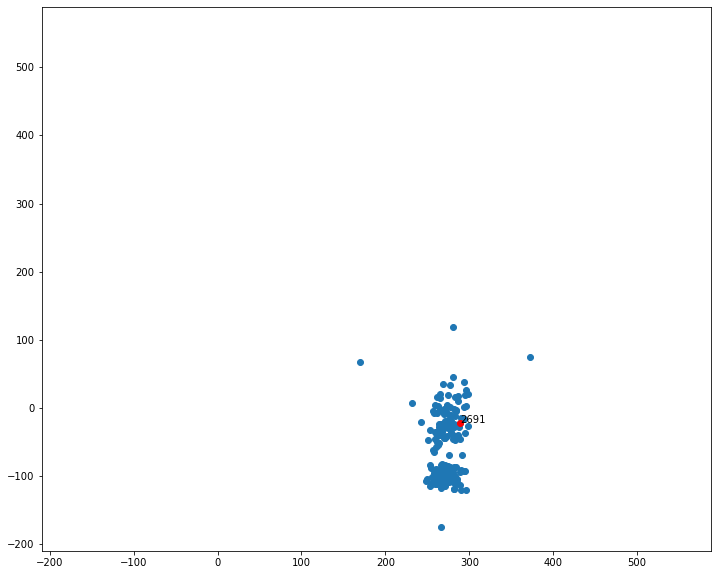

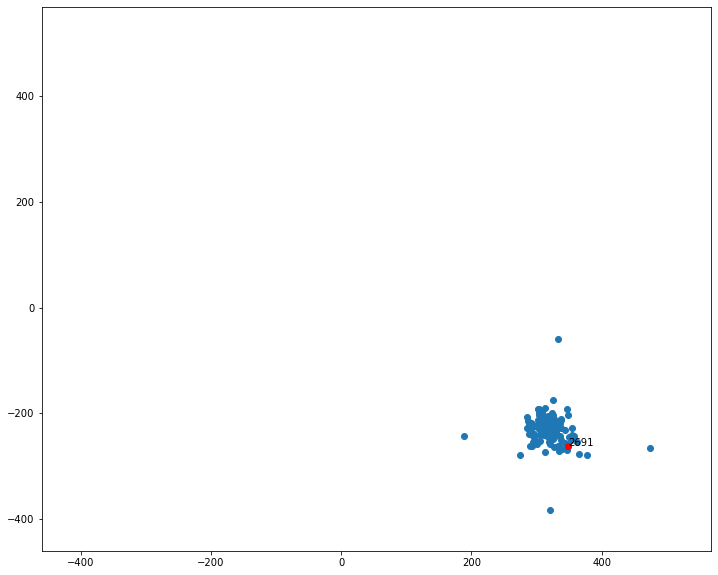

In [47]:
obs_node = 2691
for emb in patched_subnets:
    plot(emb,node_list, m=2, annotate=False, node=obs_node)

### 2. Group Merge

In [195]:
[G,H] = gen_rand_subgraphs(FB_Net,N=2,size=100)

C:\Users\ruiji\AppData\Local\Temp/ipykernel_4140/1179480307.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_source_nodes = random.sample(graph.nodes,N)


In [206]:
test_net = nx.union(G,H,rename=('g-','h-'))
edges_to_add = [(a,b) for a,b in zip(G.nodes,H.nodes)]
random.shuffle(edges_to_add)
for i in range(25):
    a,b = edges_to_add[i]
    test_net.add_edge(a,b)


In [208]:
test_adj_mat = nx.adjacency_matrix(test_net)

In [209]:
K, e, T, M, isBM, times = 2, 0.0001, 12, 5, True, 5
k_clusters = 2
labels, score, runtime, G, fm_embedding = fmg.bestscore_choice(test_adj_mat, K, e, k_clusters, T, times, isBM)

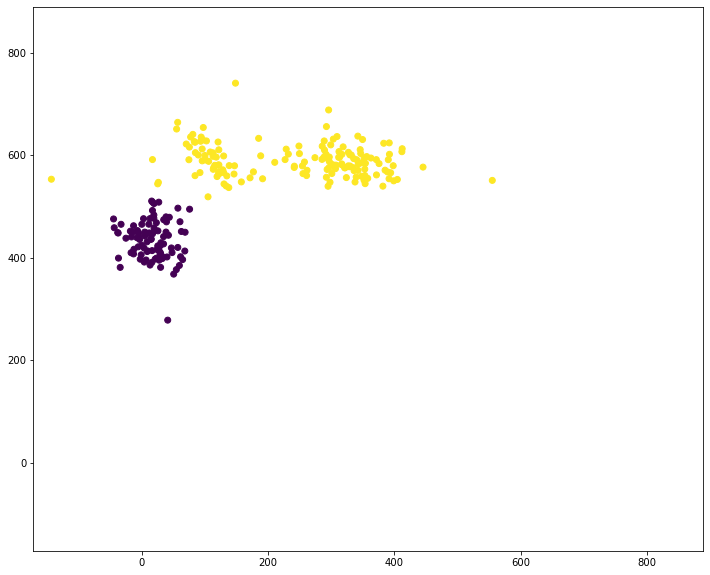

In [210]:
plot(fm_embedding,list(test_net.nodes),m=2,annotate=False,membership=labels)

In [213]:
node_list = list(test_net.nodes)
error = 0
for i in range(200):
    node = node_list[i]
    label = labels[i]
    print(f"{node}:{label}")
    if (node.startswith("g") and label==0) or (node.startswith("h") and label==1):
        error += 1


g-0:1
g-1:1
g-2:1
g-3:1
g-4:1
g-5:1
g-6:1
g-7:1
g-8:1
g-9:1
g-10:1
g-11:1
g-12:1
g-13:1
g-14:1
g-15:1
g-16:1
g-17:1
g-18:1
g-19:1
g-20:1
g-21:1
g-22:1
g-23:1
g-24:1
g-25:1
g-26:1
g-27:1
g-28:1
g-29:1
g-30:1
g-31:1
g-32:1
g-33:1
g-34:1
g-35:1
g-36:1
g-37:1
g-38:1
g-39:1
g-40:1
g-41:1
g-42:1
g-43:1
g-44:1
g-45:1
g-46:1
g-47:1
g-48:1
g-49:1
g-50:1
g-51:1
g-52:1
g-53:1
g-54:1
g-55:1
g-56:1
g-57:1
g-58:1
g-59:1
g-60:1
g-61:1
g-62:1
g-63:1
g-64:1
g-65:1
g-66:1
g-67:1
g-68:1
g-69:1
g-70:1
g-71:1
g-72:1
g-73:1
g-74:1
g-75:1
g-76:1
g-77:1
g-78:1
g-79:1
g-80:1
g-81:1
g-82:1
g-83:1
g-84:1
g-85:1
g-86:1
g-87:1
g-88:1
g-89:1
g-90:1
g-127:1
g-135:1
g-184:1
g-197:1
g-251:1
g-281:1
g-284:1
g-309:1
g-320:1
h-0:0
h-517:0
h-526:0
h-1041:0
h-538:0
h-1072:0
h-563:0
h-566:0
h-58:0
h-580:0
h-596:0
h-1624:0
h-601:0
h-606:0
h-107:0
h-1131:0
h-629:0
h-637:0
h-641:0
h-649:0
h-651:0
h-1169:0
h-1703:0
h-171:0
h-1709:0
h-1748:0
h-1249:0
h-1306:0
h-1831:0
h-348:0
h-353:0
h-363:0
h-366:0
h-1904:0
h-376:0
h-896:0
h-89

In [214]:
error

5

In [218]:
def Merge_Group_Scene(graph, G, H, N = 3):
    result = [graph]
    g = graph.copy()
    g_C = nx.complement(g)
    edges_to_add = [(a,b) for a,b in zip(G.nodes,H.nodes)]
    random.shuffle(edges_to_add)
    delta = int(len(edges_to_add)/N)
    for i in range(N-1):
        for y in range(delta):
            a,b = edges_to_add[y]
            g.add_edge(a,b)
        result.append(g.copy())
    return result[::-1]

In [219]:
scg_test_series = Merge_Group_Scene(test_net, G, H, N = 3)

In [223]:
K, e, T, M, isBM, times = 2, 0.0001, 10, 4, True, 5
k_clusters = 2
BMFM_test_subnets = []
for i,test_subnet in enumerate(scg_test_series):
    print(f'Graph: {i+1}')
    labels, score, runtime, G, fm_embedding = fmg.bestscore_choice(test_adj_mat, K, e, k_clusters, T, times, isBM)
    #plot(fm_embedding,list(test_subnet.nodes), m=2, annotate=False, node=obs_node)
    BMFM_test_subnets.append((test_subnet,fm_embedding,labels))
    

Graph: 1
Graph: 2
Graph: 3


In [225]:
node_list = list(BMFM_test_subnets[0][0].nodes)
patched_subnets = []
Z0 = BMFM_test_subnets[0][1]
patched_subnets = [Z0]
for i in range(1,len(BMFM_test_subnets)):
    X1 = BMFM_test_subnets[i][1]
    Z1 = Gurobi_Patch_Solver(Z0,X1)
    patched_subnets.append(Z1)

Set parameter NonConvex to value 2
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 500 rows, 506 columns and 2000 nonzeros
Model fingerprint: 0xf185be33
Model has 500 quadratic objective terms
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-01, 9e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 7e+02]
  QRHS range       [1e+00, 1e+00]

Continuous model is non-convex -- solving as a MIP

Presolve added 4 rows and 2 columns
Presolve time: 0.01s
Presolved: 518 rows, 512 columns, 2032 nonzeros
Presolved model has 500 quadratic objective terms
Presolved model has 4 bilinear constraint(s)
Variable types: 510 continuous, 2 integer (2 binary)

Root relaxation: objective 3.583877e+07, 733 iterations, 0.06 seconds (0.03 work units)

    Node

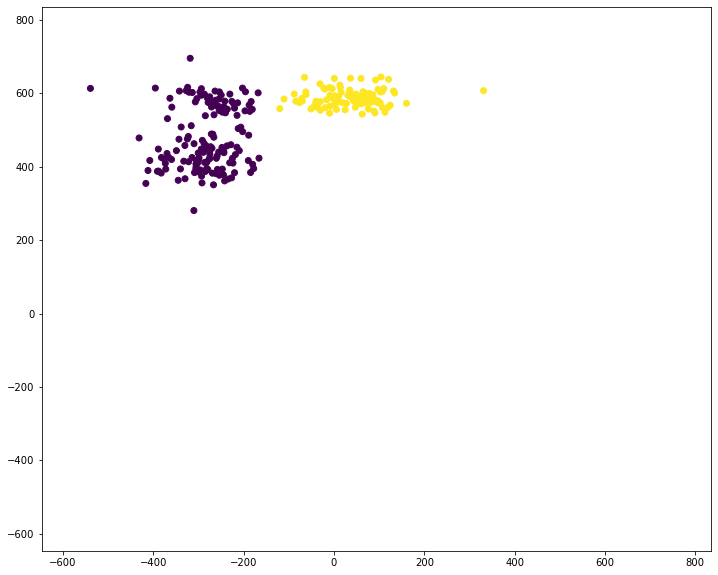

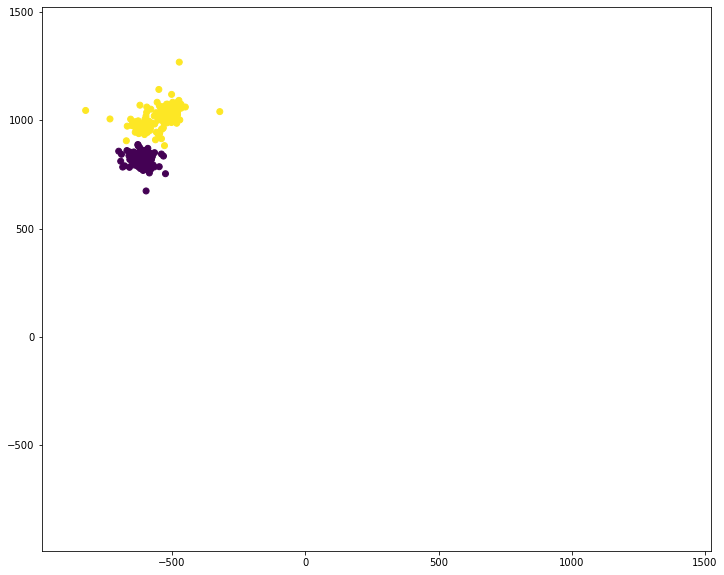

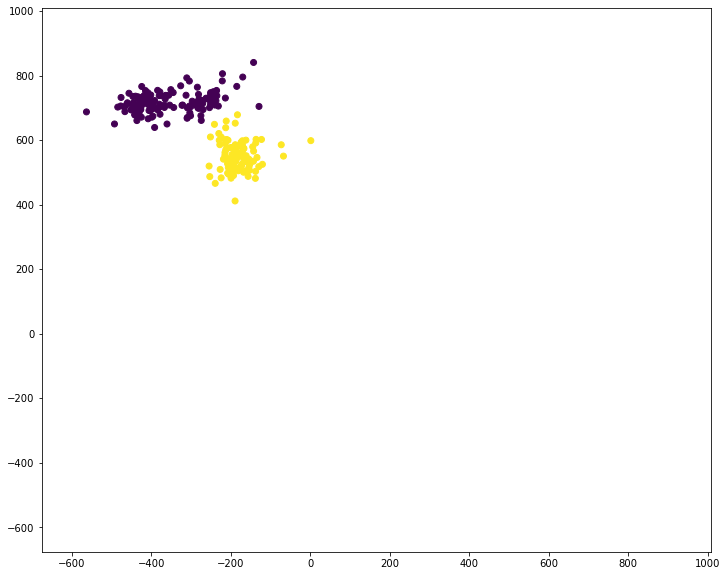

In [226]:
for i,emb in enumerate(patched_subnets):
    plot(emb,node_list, m=2, annotate=False,membership=BMFM_test_subnets[i][2])

## Improvements

1. In Dynamic FM Patching Process, it fails to find b representing linear translation.
2. How to evaluate the application performance?
3. 